# BLUFF: Sarcasm Detection on News Headlines



## Problem Statement

Sarcasm is a figure of speech and detecting its presence is an important part of natural language understanding. Depending on the context, sarcasm has the potential to flip the sentiment of a piece of text, having implications for key areas of NLP such as sentiment analysis.

Literature shows sarcasm detection exercises have been conducted on social media content, for example detecting sarcasm in tweets.

Satirical news companies such as The Onion (US based) or The Betoota Advocate (Australia based) publish sarcastic news articles, often in relation to current affairs. With a clean dataset of news headlines, we aim to construct a natural language model which can classify headlines to be either sarcastic or not sarcastic.

There are several existing NLP methods that can be used for a sequence classification problem like this, including traditional word embedding methods like word2vec, GloVe, or fastText, contextual language embedding like ELMo, and transformer-based methods like BERT (what is considered state of the art).

Our proposed method is to combine several of these into an ensemble model which improves on the performance of each individual model.

## Data Source

The dataset used was the [News Headlines Dataset for Sarcasm Detection](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection) found on Kaggle. This dataset contains headlines taken from HuffPost (not sarcastic) and The Onion (sarcastic). In comparison to tweets or other social media content, these headlines are high quality with limited spelling or grammar errors.

Version 2 of the dataset (`Sarcasm_Headlines_Dataset_v2.json`) was used as it contains more sarcastic headlines than the original dataset (creating a more balanced dataset).

## Exploratory Data Analysis

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
###### This code block reads in the raw data #####
pd.set_option('display.max_colwidth', -1)

# Load in data removing Article link column as it is unnecessary
data = pd.read_json("./data/Sarcasm_Headlines_Dataset_v2.json", lines=True).iloc[:,[0,1]]

# Show data head
data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clock of hair loss
1,0,"dem rep. totally nails why congress is falling short on gender, racial equality"
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting to work
4,1,mother comes pretty close to using word 'streaming' correctly
5,0,my white inheritance
6,0,5 ways to file your taxes with less stress
7,1,richard branson's global-warming donation nearly as much as cost of failed balloon trips
8,1,shadow government getting too large to meet in marriott conference room b
9,0,lots of parents know this scenario


Total number of headlines: 28619


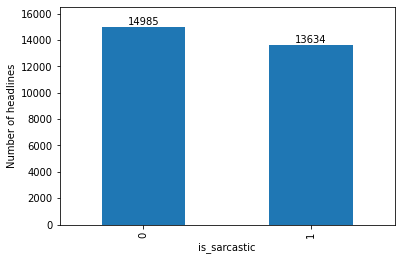

In [ ]:
# Assert no nan values
assert data.isna().sum().sum() == 0

# Check if dataset is balanced for binary classification
# Bar plot
ax = data.groupby('is_sarcastic').size().plot.bar()
ax.bar_label(ax.containers[0])
ax.set_ylabel("Number of headlines")
ax.set_ylim(0,16500)

print(f"Total number of headlines: {len(data)}")

There are 28619 headlines in total, and two classes (binary classification task) which are 0 (not sarcastic) and 1 (sarcastic). The dataset is relatively balanced, with 48% of the headlines being sarcastic.

In [ ]:
from wordcloud import WordCloud

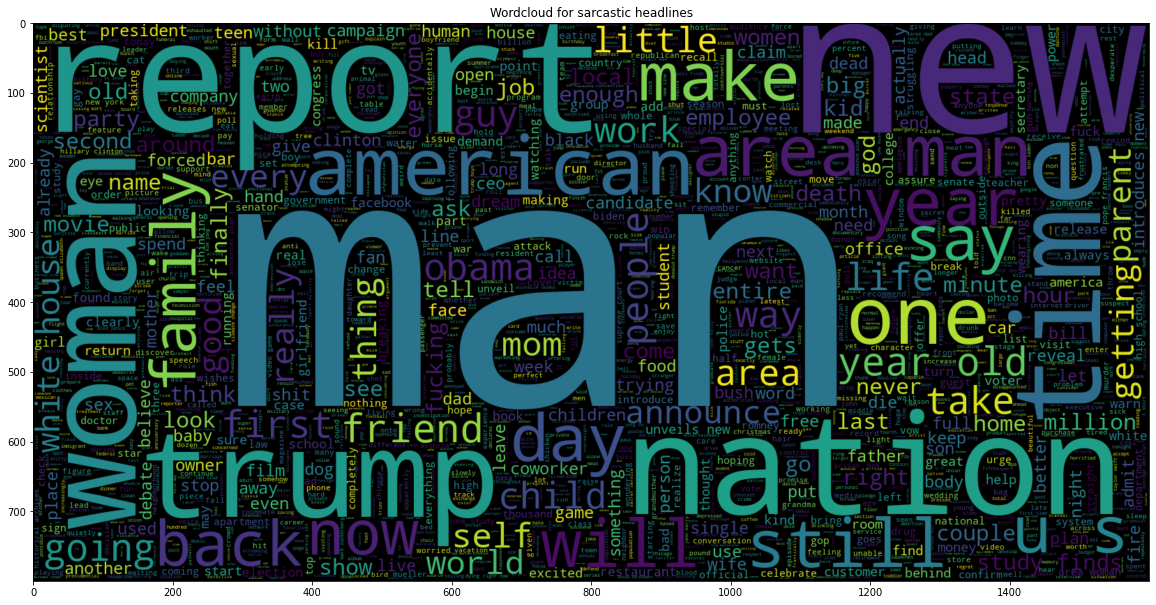

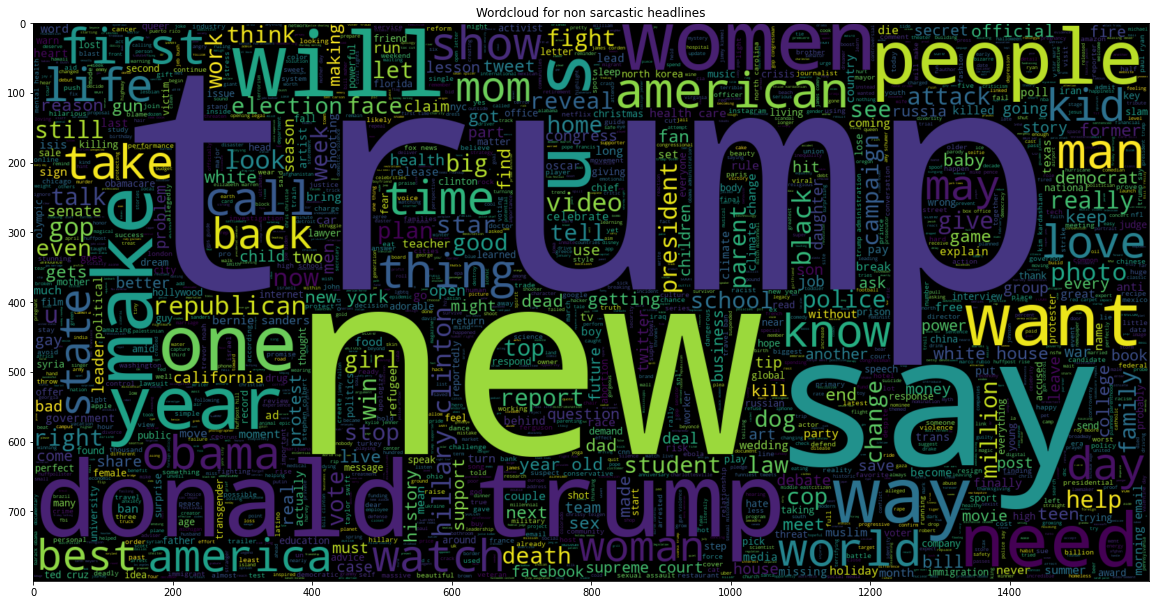

In [ ]:
#wordcloud for sarcastic text
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Wordcloud for sarcastic headlines')
plt.savefig('Wordcloud for sarcastic headlines.png')

#wordcloud for non sarcastic text
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Wordcloud for non sarcastic headlines')
plt.savefig('Wordcloud for non sarcastic headlines.png')

We see that there are some common words in both the sarcastic and not sarcastic headlines (eg. Trump), but have some distinct differences in the language used. 

## Data Preparation

We first split the dataset into training and testing sets (75:25) and save these to files so that each model is trained and evaluated on the same data. Both subsets are balanced for binary classification.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(data,test_size=0.25,stratify=data['is_sarcastic'],random_state=69)

print("\nBalanced for train set\n")
print(train.groupby('is_sarcastic').count())

print("---------------------------------------------------")

print("\nBalanced for test set\n")
print(test.groupby('is_sarcastic').count())

train.to_csv('./data/train.csv',index=False)
test.to_csv('./data/test.csv',index=False)



Balanced for train set

              headline
is_sarcastic          
0             11239   
1             10225   
---------------------------------------------------

Balanced for test set

              headline
is_sarcastic          
0             3746    
1             3409    


As described below, 5 models were trained on this dataset. Some models required different data preparation processes, so further data preparation has been done in the respective notebooks for each model.

## Methods and Models

5 models were constructed:
* DistilBERT
    * The pretrained DistilBERT base model with uncased vocab was used, fine-tuned with a single linear layer to classify sequences. The HuggingFace library's DistilBertForSequenceClassification interface was used.
    * The DistilBERT model was used over BERT for convenience in this project (model size is 40% smaller and trains 60% faster than BERT with minimal dropoff in performance).
    * The `bert.ipynb` notebook shows results for training under DistilBERT, however this can be easily switched to train using the BERT pretrained model in the code.
* word2vec
    * Word2Vec vectors for the dataset is produced by the `gensim.models.Word2Vec` library
    * These vectors are used in a neural network with Keras sequential API consisting of bi-directional LSTM and GRU layers. Final layer has a sigmoid transfer function for binary classification.
    * Code implementing word2vec is available at `word2vec.ipynb`

* GloVe
    * Similar to word2vec, pretrtained emeddings are downloaded and embedding vectors are produced for classification
    * These vectors are used in a neural network with Keras sequential API with a bidirectional LSTM and sigmoid dense layer
    * Code implementing word2vec is available at `GloVe.ipynb`

* fastText
    * fastText is a library for efficient learning of word representations and sentence classification that uses pre trained word vectors
    * Inputs were modified for fastext training and model was trained and tested at `fastText.ipynb`
* ELMo
    * ELMo is a novel way to represent words in vectors or embeddings. The embeddings used were from [here](https://tfhub.dev/google/elmo/3) at tensorflow hub
    * ELMo word vectors are computed on top of a two-layer bidirectional language model (biLM) that uses LSTM's
    * Unlike traditional word embeddings, the ELMo vector assigned to a word is actually a function of the entire sentence. Hence, the same word can have different word vectors under different contexts
    * A logistic regression was used for our binary classification problem with the vectors produced by the embeddings
    * Code implementing ELMo is at `ELMo.ipynb`

After analysing and comparing their individual performances, an ensemble model was created by computing weighted averages of the prediction probabilities (see Ensemble Modelling section).

## Results

We will now analyse and compare the performance of each individual model.

### Analysis Setup

In [ ]:
import pickle

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            accuracy_score, precision_score, recall_score,\
                            matthews_corrcoef, roc_curve, roc_auc_score, f1_score

In [ ]:
test_data = test
# True labels
target = test_data['is_sarcastic']
target.head()

840      0
1414     1
9726     1
9477     0
23481    0
Name: is_sarcastic, dtype: int64

###### Load prediction probabilities from each model

In [ ]:
# Load DistilBERT Probabilities
distilbert_probabilities = pickle.load(open("model_probabilities/prediction_probabilities_distilbert_3.pkl", 'rb'))
distilbert_pred_prob_1 = distilbert_probabilities[:,1].numpy()

# Get binary classification from prediction probabilities
distilbert_predictions = np.argmax(distilbert_probabilities, axis=1)

In [ ]:
# Load word2vec probabilities
word2vec_pred_prob_1 = pickle.load(open("model_probabilities/word2vec_probs_for_1.pkl", 'rb'))
word2vec_pred_prob_1 = word2vec_pred_prob_1.flatten()

In [ ]:
# Load GloVe probabilities
glove_pred_prob_1 = pickle.load(open("model_probabilities/glove_probs_for_1.pkl", 'rb'))
glove_pred_prob_1 = glove_pred_prob_1.flatten()

In [ ]:
# Load ELMo probabilities
elmo_pred_prob_1 = pickle.load(open("model_probabilities/elmo_probs_for_1.pkl", 'rb'))
elmo_pred_prob_1 = elmo_pred_prob_1.flatten()

In [ ]:
# Load FastText probabilities
fasttext_pred_prob_1 = np.array(pickle.load(open("model_probabilities/fasttext_probs_for_1.pkl", 'rb')))

In [ ]:
models = [
  {
    "name": "DistilBERT",
    "pred_prob_1": distilbert_pred_prob_1
  },
  {
    "name": "word2vec",
    "pred_prob_1": word2vec_pred_prob_1
  },
  {
    "name": "GloVe",
    "pred_prob_1": glove_pred_prob_1
  },
  {
    "name": "ELMo",
    "pred_prob_1": elmo_pred_prob_1
  },
  {
    "name": "fastText",
    "pred_prob_1": fasttext_pred_prob_1
  }
]

### Performance statistics per model

In this section we compare the performance of our models based on different evaluation matrices.

In [ ]:
def get_performance_stats(models):
  performance_stats = []
  for model in models:
    # Get the binary classification prediction from the prediction probability for 1 (headline is sarcastic)
    predictions = (np.array(model["pred_prob_1"]) > 0.5).astype(int)

    # get performance metrics
    performance_stats.append(
          {
            "Model": model["name"],
            "Accuracy": accuracy_score(target, predictions),
            "Precision": precision_score(target, predictions),
            "Recall": recall_score(target, predictions),
            "MCC": matthews_corrcoef(target, predictions),
            "F1": f1_score(target, predictions),
            "Confusion Matrix": confusion_matrix(target, predictions),
            "ROC Curve": roc_curve(target, model["pred_prob_1"]),
            "ROC AUC Score": roc_auc_score(target, model["pred_prob_1"])
          })
    
  return performance_stats

In [ ]:
performance_stats = get_performance_stats(models)
performance_df = pd.DataFrame(performance_stats)
pd.set_option('precision', 2)
performance_df.iloc[:,:6]

,Model,Accuracy,Precision,Recall,MCC,F1
0,DistilBERT,0.92,0.93,0.90,0.84,0.92
1,word2vec,0.88,0.86,0.88,0.75,0.87
2,GloVe,0.82,0.83,0.79,0.64,0.81
3,ELMo,0.79,0.79,0.76,0.58,0.78
4,fastText,0.81,0.82,0.78,0.62,0.80


#### Accuracy, precision, and recall

In this secion we compare our five models based on three different evaluation matrices. 

Text(0.5, 1.0, 'Model Performance')

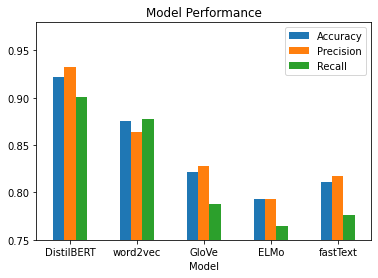

In [ ]:
ax = performance_df.plot.bar(x='Model', y=['Accuracy', 'Precision', 'Recall'], rot=0)
ax.set_ybound(lower=0.75)
ax.set_title("Model Performance")

The graph above shows that DistilBERT has the highest accuracy, Precision and Recall and ELMo has the lowest accuracy, precision and Recal among all of our models.

Precision is the number of true positive results divided by the number of all positive results (TP+FP), including those not identified correctly. It is a good evaluation when the cost of false positive is high. 

Recall is the number of true positive results divided by the number of all samples that should have been identified as positive (TP+FN).

It's worth mentioning in this particular scenario, the cost of false positive is not high.

#### F1 Score

Text(0.5, 1.0, 'F1 Score')

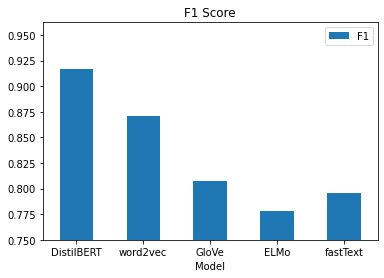

In [ ]:
ax = performance_df.plot.bar(x='Model', y='F1', rot=0)
ax.set_ybound(lower=0.75)
ax.set_title("F1 Score")

F1 Score is the harmonic mean of precision and recall.

#### Confusion Matrices

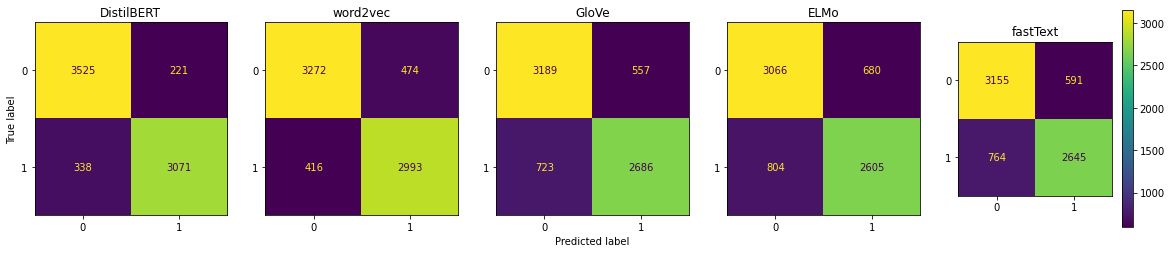

In [ ]:
# Plot confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
for i, model in enumerate(performance_stats):
  disp = ConfusionMatrixDisplay(confusion_matrix=model["Confusion Matrix"])
  disp.plot(ax=axes[i])
  disp.ax_.set_title(model["Model"])
  if i != len(performance_stats) - 1:
    disp.im_.colorbar.remove()
  if i != int(len(performance_stats) / 2):
    disp.ax_.set_xlabel('')
  if i != 0:
    disp.ax_.set_ylabel('')

Confusion Matrix or Error Matrix is an indication of the error of the model. Each cell of the matrix indicates the number of True Positive(bottom right) or the number of False Poitive(top right) or the number of True Negative(top left) or the number of False Negative(bottom left). For most of the models the number of False Negatives is more than the number of False Positives.

#### ROC Curves

Text(0.5, 1.0, 'ROC Curves')

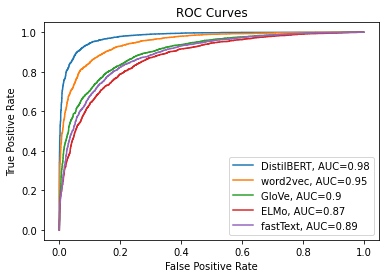

In [ ]:
plt.figure(0).clf()

# Plot ROC curves
for i, model in enumerate(performance_stats):
  fpr, tpr, _ = model["ROC Curve"]
  auc = model["ROC AUC Score"]
  plt.plot(fpr,tpr,label=f"{model['Model']}, AUC={round(auc, 2)}")

plt.legend()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curves")

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots TPR(True Postive Rate) vs. FPR(False Positive Rate) at different classification thresholds. A model wich reached maximum True Positive Rate at minimum of False Postive Rate has better performace (DistilBERT in this example).
AUC (Area Under the ROC Curve) measures the entire two-dimensional area underneath the entire ROC curve. AUC provides an aggregate measure of performance across all possible classification thresholds. AUC closer to 1 means better the performance of the model in binary classification


#### Matthews' Correlation Coefficient (MCC)

Text(0.5, 1.0, "Matthews' Correlation Coefficients")

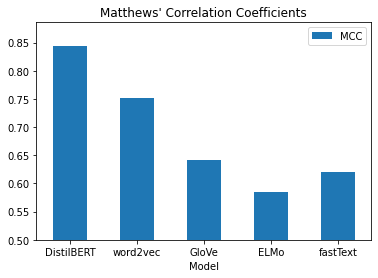

In [ ]:
ax = performance_df.plot.bar(x='Model', y='MCC', rot=0)
ax.set_ybound(lower=0.5)
ax.set_title("Matthews' Correlation Coefficients")

The Matthews correlation coefficient (MCC) is a more reliable statistical rate which produces a high score only if the prediction obtained good results in all of the four confusion matrix categories (true positives, false negatives, true negatives, and false positives). Hight MCC indicates high correlation between the predicted result and the actual result

## Ensemble Modelling

Our goal is to improve on our top performing model (DistilBERT) by creating an ensemble with the other 4 models.

### Initial ensemble (excluding DistilBERT)

We first combine the 4 underperforming models (word2vec, GloVe, fastText, ELMo) into our initial ensemble.

We will use the Matthews Correlation Coefficient to weight each model in the ensemble.

In [ ]:
# Choose an offset (less than minimum MCC = 0.58)
# higher offset will give larger (more extreme) weighting to better models
offset = 0.5

#### Weight calculations exclude DistilBERT

# get model weight based on model's MCC value
def get_model_weight(mcc_val):
  return (mcc_val - offset)/sum(performance_df.loc[1:,'MCC'] - offset)

performance_df['Weight'] = performance_df.apply(lambda row: get_model_weight(row['MCC']), axis=1)

# Check that sum of weights is equal to 1
print(f"Sum of weights = {sum(performance_df.loc[1:,'Weight'])}")

# Display weight for each model
performance_df.loc[1:,['Model', 'MCC', 'Weight']]

Sum of weights = 1.0


,Model,MCC,Weight
1,word2vec,0.75,0.42
2,GloVe,0.64,0.24
3,ELMo,0.58,0.14
4,fastText,0.62,0.20


We then compute combined prediction probabilties based on these weights.

In [ ]:
# Array for initial ensemble's prediction probability for 1 (headline is sarcastic)
# Initialized as zeros
ensemble_pred_probs = np.zeros_like(distilbert_pred_prob_1, dtype='float64')

#### Does not include DistilBERT
for model in models[1:]:
  # Get weight from dataframe
  weight = performance_df.loc[performance_df['Model'] == model['name'], 'Weight'].iloc[0]
  # Add weighted probability
  ensemble_pred_probs = np.add(ensemble_pred_probs, weight * model['pred_prob_1'])

# Get binary classification
initial_ensemble_predictions = (ensemble_pred_probs > 0.5).astype(int)

In [ ]:
print(f"Accuracy: {round(accuracy_score(target, initial_ensemble_predictions), 3)}")
print(f"Precision: {round(precision_score(target, initial_ensemble_predictions), 3)}")
print(f"Recall: {round(recall_score(target, initial_ensemble_predictions), 3)}")

print(f"MCC: {round(matthews_corrcoef(target, initial_ensemble_predictions), 3)}")

Accuracy: 0.885
Precision: 0.882
Recall: 0.876
MCC: 0.769


This is a slight improvement on the highest performing model of the 4 included in the ensemble model (word2vec, MCC = 0.75). However, it still underperforms the DistilBERT model. 

Our next step is to weight this intial ensemble with the DistilBERT model.

### Final ensemble

We want to combine our initial ensemble with the best performing model, DistilBERT. Our first step is to explore how different weights for these two models improves performance. Our metric of choice is MCC, so we want to find the weighting for the DistilBERT model which will maximise MCC.

In [ ]:
bert_weight = np.arange(0, 1, 0.01)

mccs = np.zeros_like(bert_weight)
for i, w in enumerate(bert_weight):
  e_pred_probs_with_bert = np.add(ensemble_pred_probs *(1 - w), distilbert_pred_prob_1 * w)
  e_predictions = (e_pred_probs_with_bert > 0.5).astype(int)
  mccs[i] = matthews_corrcoef(target, e_predictions)

Text(0, 0.5, "Matthews' Correlation Coefficient")

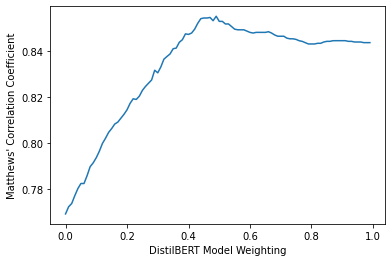

In [ ]:
plt.plot(bert_weight, mccs)
plt.xlabel("DistilBERT Model Weighting")
plt.ylabel("Matthews' Correlation Coefficient")

The highest MCC produced is around 0.5. Zooming in on the [0.4, 0.6] region:

In [ ]:
bert_weight = np.arange(0.4, 0.6, 0.001)

mccs = np.zeros_like(bert_weight)
for i, w in enumerate(bert_weight):
  e_pred_probs_with_bert = np.add(ensemble_pred_probs *(1 - w), distilbert_pred_prob_1 * w)
  e_predictions = (e_pred_probs_with_bert > 0.5).astype(int)
  mccs[i] = matthews_corrcoef(target, e_predictions)

Text(0, 0.5, "Matthews' Correlation Coefficient")

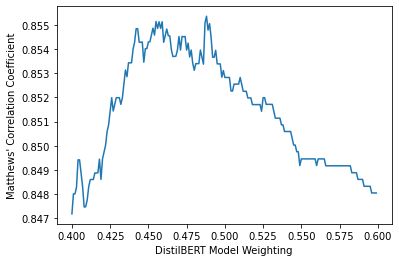

In [ ]:
plt.plot(bert_weight, mccs)
plt.xlabel("DistilBERT Model Weighting")
plt.ylabel("Matthews' Correlation Coefficient")

Finding the weighting giving the maximum MCC:

In [ ]:
bert_weight[np.argmax(mccs)]

0.4880000000000001

So we choose to give the DistilBERT model a weighting of 48.8%.

In [ ]:
final_ensemble_pred_probs = np.add(ensemble_pred_probs * 0.512, distilbert_pred_prob_1 * 0.488)

# Get the binary classification prediction from prediction probability
final_ensemble_predictions = (final_ensemble_pred_probs > 0.5).astype(int)

### Results for final model

In [ ]:
all_models = models + [{"name": "Ensemble", "pred_prob_1": final_ensemble_pred_probs}]

all_performance_stats = pd.DataFrame(get_performance_stats(all_models))

all_performance_stats.iloc[-1,:6]

Model        Ensemble
Accuracy     0.93    
Precision    0.94    
Recall       0.91    
MCC          0.86    
F1           0.92    
Name: 5, dtype: object

Hence, adding information from the other 4 models has added a slight improvement on the performance of the DistilBERT model in all 5 metrics used.

#### Confusion Matrix

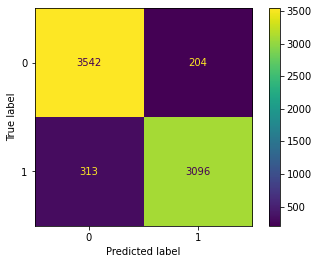

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(target, final_ensemble_predictions))
disp.plot()

#### Qualitative Observations

Let's examine how the headlines were classified by our final model.

In [ ]:
# Extract the false positive headlines (model labeled as sarcastic but was serious)
false_positives = test_data.iloc[np.where(np.logical_and(final_ensemble_predictions == 1, target == 0))[0],:]
false_positives

,is_sarcastic,headline
8199,0,justin bieber interrupts performance to scold spanish audience
15755,0,scott walker issues executive order allowing national guard members to carry weapons
2954,0,bear's plan to break into man's home foiled by cat door
1966,0,france's far-right national front unveils new name with pro-nazi past
13493,0,walmart quits selling ar-15s and military-style rifles
...,...,...
5577,0,scientists reveal secret to boosting your metabolism during sleep
13122,0,congress passes 34th short-term funding patch for highways
7051,0,trapped mexican bakery staff bake hundreds of loaves for harvey flood victims
15192,0,sharon stone slammed by 'golden boy' director


In [ ]:
# Extract false negatives (headline was sarcastic but model classified it as not)
false_negatives = test_data.iloc[np.where(np.logical_and(final_ensemble_predictions == 0, target == 1))[0],:]
false_negatives

,is_sarcastic,headline
1414,1,theodore roosevelt was a gay man
26458,1,winter storm threatens homeless man's plans to survive over thanksgiving
13544,1,"spielberg panics, adds comical groin injuries to 'lincoln'"
3025,1,chevron touts green initiative with hybrid-powered oil drilling platforms
21680,1,republicans outraged over redtube censoring of conservative voices
...,...,...
13347,1,ohio state uses t-shirt blaster to pass out diplomas
2296,1,women's prison riot feels gratuitous
16447,1,chuck schumer condemns mitch mcconnell for being way better at this than him
19170,1,clinton 'very disappointed' in missouri


In [ ]:
true_positives = test_data.iloc[np.where(np.logical_and(final_ensemble_predictions == 1, target == 1))[0],:]
true_negatives = test_data.iloc[np.where(np.logical_and(final_ensemble_predictions == 0, target == 0))[0],:]

Text(0.5, 1.0, 'Wordcloud for false negatives')

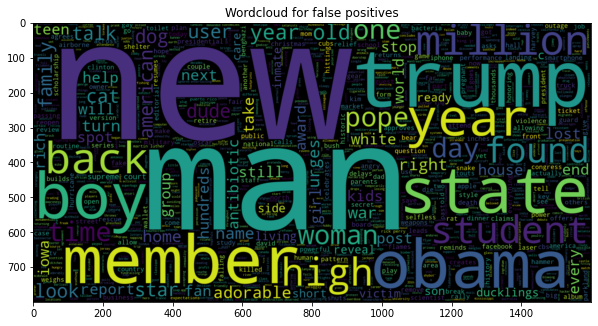

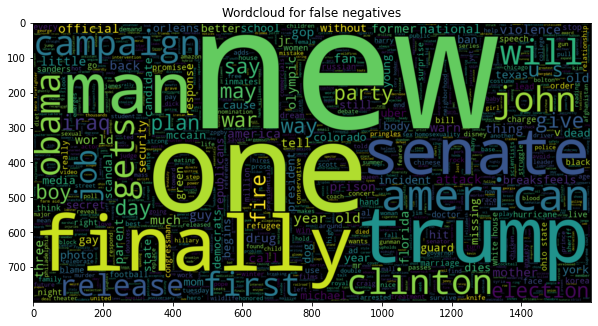

In [ ]:
#wordcloud for false positives
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(false_positives.headline))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Wordcloud for false positives')

#wordcloud for false negatives
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(false_negatives.headline))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Wordcloud for false negatives')

Comparing these word clouds with the word clouds produced for the correctly labelled headlines (in Exploratory Data Analysis), one of the most frequently found words in the false positives, 'man', was also found frequently in the sarcastic headlines, more so than in the non-sarcastic headlines.

Text(0.5, 1.0, 'Wordcloud for true negatives')

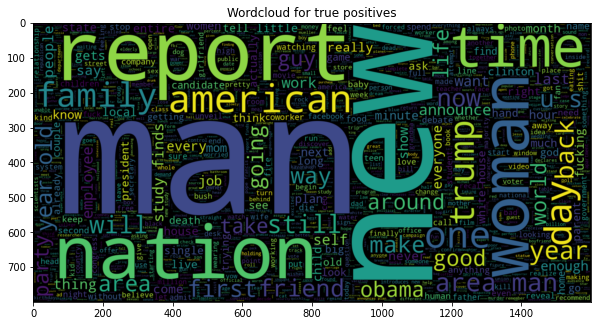

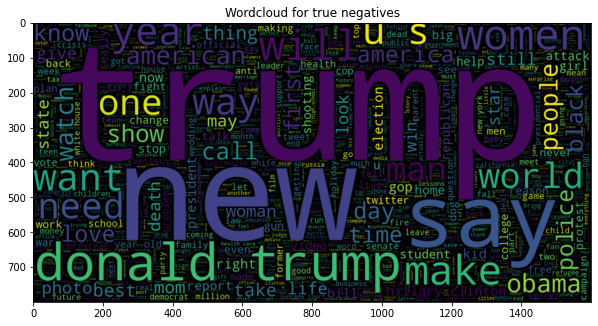

In [ ]:
#wordcloud for true positives
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(true_positives.headline))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Wordcloud for true positives')

#wordcloud for true negatives
plt.figure(figsize = (10,10)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(true_negatives.headline))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Wordcloud for true negatives')

The word 'new' appears frequently in all quadrants.

## Discussion

The ensemble model was successful in boosting model performance. With 93% accuracy, we do not believe that this model is sufficient to replace human judgment, however it could act as a guide providing a suggested classification.

Our model had more false negatives than false positives (better precision than recall), which interestingly, mirrors how humans misinterpret sarcasm. People can often miss sarcastic comments and interpret them to be serious, more frequently than they interpret a serious comment to be sarcastic.

This task is similar to fake news detection and has similar limitations - to truly detect sarcasm, much more outside context would be needed, and frequently humans themselves cannot understand sarcasm when they lack the necessary contextual knowledge. This means that the model may not be effective in classifying sarcastic headlines in other contexts (eg. headlines from Australia, headlines in the future, or headlines from other news outlets) as the topics may vary from those the model was trained on, and as such the model would lack the data representing this knowledge. Bias may also come from the headline sources, with the models potentially differentiating between HuffPost and The Onion, rather than sarcasm itself. 

Commenting on the individual models, the DistilBERT model had the best performance in all metrics, matching the state-of-the-art status the BERT family of models possess in NLP. During training, it did not appear that the model was overfitting (based on validation loss) after 3 epochs, however it would be worth investigating during future work whether 2 epochs would be sufficient to produce similar results.

While DistilBERT provided the best model performance, it was the most computationally expensive model used. Even with DistilBERT being significantly more lightweight than BERT, it contains 110M parameters and needed to be trained on GPU to avoid excessively long training times (even with a relatively small dataset such as the one used in this project).

The worst performing model was ELMo - this could be attributed to only a simple logistic regression model being applied on top of the embeddings produced by ELMo. In comparison, the word2vec model with neural network layers on top of the word vectors was able to produce the second-best performance of the models. Future work would include applying neural network layers on top of ELMo (instead of a logistic regression) to investigate if this could improve its performance in this classification task.

Hyperparameters played a significant role in some models. WordNGrams is a hyperparameter in FastText that determines sentence split to create embedding vectors. It needed a careful assessment to choose the optimal number, where, having a low number removed contextual information. Dropout rates in LSTM and GRU layers also impacted the results. Sequential models with high learning rates cannot converge loss to a minimum, hence some balancing was needed to produce good performing models. The max iterations parameters in ELMo model's logistic regression needed to be tuned so that the convergence to minimum fully occurs for optimal result. These hyperparameters along with batch size and number of epochs played a role in how well a model performs.

From the word clouds in the Qualitative Observations section, it appears that the word 'new' is commonly found in all 4 quadrants (true positives and negatives, false positives and negatives). It could be that in this particular task, the word 'new' does not add any useful information, so future work to further improve on this task could include treating 'new' as a stopword.